# Prior Sensitivity Analysis for Media Mix Models

This notebook demonstrates **prior sensitivity analysis** for Bayesian MMM models—a critical step in causal inference.

## Why Prior Sensitivity Analysis?

Unlike hyperparameters (model structure), **priors encode causal assumptions** about how marketing affects sales:
- Direction of effects (ads → sales)
- Plausible magnitude ranges (ROAS bounds)
- Saturation behavior (diminishing returns)
- Carryover patterns (adstock decay)

**Key principle**: We should NOT optimize priors using cross-validation (as discussed in the causal inference analysis). Instead, we:
1. Define multiple **reasonable prior specifications** based on domain knowledge
2. Fit separate models with each specification
3. Compare results to understand **prior influence** on posteriors
4. Assess **robustness** of causal conclusions

## What Priors Should We Analyze?

Based on PyMC-Marketing's MMM implementation, key priors to examine:

### 1. **saturation_beta** (Channel Effect Magnitude)
- Controls scale of media effects
- Directly impacts ROAS estimates
- Most important for causal interpretation

### 2. **saturation_lam** (Saturation Half-Point)
- Where diminishing returns kick in
- Affects optimal budget allocation

### 3. **adstock_alpha** (Carryover Rate)
- How long effects persist
- Critical for dynamic optimization

### 4. **likelihood_sigma** (Observation Noise)
- Measurement uncertainty
- Affects credible interval width

### 5. **intercept** (Baseline Sales)
- Sales level without marketing
- Affects attribution percentages

## Analysis Strategy

We'll use the **optimal model structure** from notebook 03 (CRPS-optimized):
- `yearly_seasonality = 3`
- `adstock_max_lag = 10`

Then vary priors to see how causal estimates (ROAS) change while keeping model structure fixed.

## Runtime Considerations

- Each model fit: ~2-3 minutes with NumPyro (1000 draws/tune, 2 chains)
- 3 prior specs × 2-3 key parameters = ~6-9 model fits
- Total runtime: ~15-25 minutes

Let's begin!

## Setup

In [1]:
from pathlib import Path
from typing import Any
import warnings

import arviz as az
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_extras.prior import Prior
from rich import print as rprint
from rich.console import Console
from rich.table import Table

## Configuration

In [2]:
# Use optimal model structure from notebook 03 (CRPS optimization)
YEARLY_SEASONALITY = 3
ADSTOCK_MAX_LAG = 10

# MCMC settings (moderate for speed)
DRAWS = 1000
TUNE = 1000
CHAINS = 2

# Use NumPyro for speed
USE_NUMPYRO = True
NUTS_SAMPLER = "numpyro" if USE_NUMPYRO else "pymc"

# Random seed
RANDOM_SEED = 42

rprint("[bold blue]Configuration:[/bold blue]")
rprint(f"Model structure: yearly_seasonality={YEARLY_SEASONALITY}, adstock_max_lag={ADSTOCK_MAX_LAG}")
rprint(f"MCMC: {DRAWS} draws, {TUNE} tune, {CHAINS} chains")
rprint(f"Sampler: [yellow]{NUTS_SAMPLER}[/yellow]")

Configuration:

Model structure: yearly_seasonality=3, adstock_max_lag=10

MCMC: 1000 draws, 1000 tune, 2 chains

Sampler: numpyro

## Load Data

In [3]:
def load_mmm_data(data_path: str | Path) -> pl.DataFrame:
    """Load MMM data from CSV file.
    
    Args:
        data_path: Path to the mmm_data.csv file
        
    Returns:
        Polars DataFrame with parsed date column
    """
    return pl.read_csv(data_path).with_columns(
        pl.col("date").str.to_date()
    )


# Load the data
data_path = Path("../data/mmm-simple/mmm_data.csv")
df = load_mmm_data(data_path)

# Convert to pandas for PyMC-Marketing
df_pandas = df.to_pandas()

# Define model inputs
channel_columns = [
    "x1_Search-Ads",
    "x2_Social-Media",
    "x3_Local-Ads",
    "x4_Email"
]

control_columns = ["c1", "c2"]

# Prepare X and y
X = df_pandas.drop(columns=["y"])
y = df_pandas["y"]

rprint(f"\n[bold green]Data loaded successfully[/bold green]")
rprint(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
rprint(f"Channels: [yellow]{channel_columns}[/yellow]")
rprint(f"Controls: [yellow]{control_columns}[/yellow]")

Data loaded successfully

Shape: 104 rows × 11 columns

Channels: ['x1_Search-Ads', 'x2_Social-Media', 'x3_Local-Ads', 'x4_Email']

Controls: ['c1', 'c2']

## Load Ground Truth

We'll use ground truth ROAS to evaluate which prior specification yields more accurate causal estimates.

In [4]:
def load_ground_truth(ground_truth_path: str | Path) -> dict[str, Any]:
    """Load ground truth parameters.
    
    Args:
        ground_truth_path: Path to ground truth JSON
        
    Returns:
        Dictionary with ground truth parameters
    """
    with open(ground_truth_path) as f:
        return json.load(f)


ground_truth_path = Path("../data/mmm-simple/ground_truth_parameters.json")
ground_truth = load_ground_truth(ground_truth_path)

# Extract true ROAS
true_roas = ground_truth["roas_values"]["Local"]

rprint("\n[bold magenta]Ground Truth ROAS:[/bold magenta]")
for channel, roas in true_roas.items():
    rprint(f"  {channel}: [green]{roas:.2f}[/green]")

Ground Truth ROAS:

Search-Ads: 8.19

Social-Media: 21.95

Local-Ads: 3.32

Email: 32.13

## Define Prior Specifications

We'll test three prior specifications for each key parameter:
1. **Tight priors**: Strong beliefs (small variance)
2. **Default priors**: PyMC-Marketing defaults (weakly informative)
3. **Loose priors**: Very weak beliefs (large variance)

### PyMC-Marketing Default Priors

```python
intercept: Normal(mu=0, sigma=2)
saturation_beta: HalfNormal(sigma=2)  # Channel effect magnitude
saturation_lam: Gamma(alpha=3, beta=1)  # Saturation half-point
adstock_alpha: Beta(alpha=1, beta=3)  # Carryover rate
likelihood_sigma: HalfNormal(sigma=2)  # Observation noise
gamma_control: Normal(mu=0, sigma=2)  # Control variable effects
```

### Our Sensitivity Analysis

We'll focus on the **two most important priors** for causal inference:
1. **saturation_beta** - Controls channel effect magnitude (ROAS)
2. **likelihood_sigma** - Controls noise vs signal attribution

In [5]:
# Define prior specifications
prior_specs = {
    "tight_saturation_beta": {
        "name": "Tight saturation_beta",
        "description": "Strong belief: effects are small (sigma=0.5)",
        "config": {
            "saturation_beta": Prior("HalfNormal", sigma=0.5)
        },
        "rationale": "Conservative: assumes marketing has modest effects"
    },
    "default": {
        "name": "Default priors",
        "description": "PyMC-Marketing defaults (weakly informative)",
        "config": None,  # Use defaults
        "rationale": "Standard practice: let data dominate"
    },
    "loose_saturation_beta": {
        "name": "Loose saturation_beta",
        "description": "Weak belief: effects could be large (sigma=5)",
        "config": {
            "saturation_beta": Prior("HalfNormal", sigma=5)
        },
        "rationale": "Agnostic: allow for strong marketing effects"
    },
    "tight_likelihood": {
        "name": "Tight likelihood_sigma",
        "description": "Low noise: data is very precise (sigma=0.5)",
        "config": {
            "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=0.5))
        },
        "rationale": "Assumes measurement is accurate, more credit to model"
    },
    "loose_likelihood": {
        "name": "Loose likelihood_sigma",
        "description": "High noise: data is noisy (sigma=5)",
        "config": {
            "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=5))
        },
        "rationale": "Assumes measurement has errors, wider credible intervals"
    },
}

# Display prior specifications
console = Console()
table = Table(
    title="Prior Specifications for Sensitivity Analysis",
    show_header=True,
    header_style="bold cyan"
)

table.add_column("Spec ID", style="yellow")
table.add_column("Name")
table.add_column("Description")
table.add_column("Rationale")

for spec_id, spec in prior_specs.items():
    table.add_row(
        spec_id,
        spec["name"],
        spec["description"],
        spec["rationale"]
    )

console.print(table)

                                   Prior Specifications for Sensitivity Analysis                                   
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Spec ID               ┃ Name                   ┃ Description                   ┃ Rationale                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ tight_saturation_beta │ Tight saturation_beta  │ Strong belief: effects are    │ Conservative: assumes          │
│                       │                        │ small (sigma=0.5)             │ marketing has modest effects   │
│ default               │ Default priors         │ PyMC-Marketing defaults       │ Standard practice: let data    │
│                       │                        │ (weakly informative)          │ dominate                       │
│ loose_saturation_beta │ Loose saturation_beta  │ Weak belief: effects could be │ Agnostic: allow for strong     │
│                       │                        │ large (sigma=5)               │ marketing effects              │
│ tight_likelihood      │ Tight likelihood_sigma │ Low noise: data is very       │ Assumes measurement is         │
│                       │                        │ precise (sigma=0.5)           │ accurate, more credit to model │
│ loose_likelihood      │ Loose likelihood_sigma │ High noise: data is noisy     │ Assumes measurement has        │
│                       │                        │ (sigma=5)                     │ errors, wider credible         │
│                       │                        │                               │ intervals                      │
└───────────────────────┴────────────────────────┴───────────────────────────────┴────────────────────────────────┘

## Helper Functions

In [6]:
def fit_mmm_with_priors(
    X: pd.DataFrame,
    y: pd.Series,
    channel_columns: list[str],
    control_columns: list[str],
    yearly_seasonality: int,
    adstock_max_lag: int,
    model_config: dict[str, Any] | None,
    draws: int,
    tune: int,
    chains: int,
    nuts_sampler: str,
    random_seed: int,
    spec_name: str
) -> MMM:
    """Fit MMM model with specified prior configuration.
    
    Args:
        X: Input features
        y: Target variable
        channel_columns: List of channel column names
        control_columns: List of control column names
        yearly_seasonality: Number of Fourier modes
        adstock_max_lag: Maximum adstock lag
        model_config: Prior configuration (None for defaults)
        draws: Number of MCMC draws
        tune: Number of tuning steps
        chains: Number of MCMC chains
        nuts_sampler: NUTS sampler to use
        random_seed: Random seed
        spec_name: Name of prior specification (for logging)
        
    Returns:
        Fitted MMM model
    """
    rprint(f"\n[bold cyan]Fitting model with: {spec_name}[/bold cyan]")
    
    # Create model
    mmm = MMM(
        date_column="date",
        channel_columns=channel_columns,
        control_columns=control_columns,
        adstock=GeometricAdstock(l_max=adstock_max_lag),
        saturation=LogisticSaturation(),
        yearly_seasonality=yearly_seasonality,
        model_config=model_config
    )
    
    # Fit model
    mmm.fit(
        X=X,
        y=y,
        draws=draws,
        tune=tune,
        chains=chains,
        nuts_sampler=nuts_sampler,
        random_seed=random_seed,
        progressbar=False if nuts_sampler == "numpyro" else True
    )
    
    rprint(f"[green]✓ Fitting completed for {spec_name}[/green]")
    
    return mmm


def compute_roas(
    mmm: MMM,
    X: pd.DataFrame,
    channel_columns: list[str]
) -> pd.Series:
    """Compute ROAS for each channel.
    
    Args:
        mmm: Fitted MMM model
        X: Input features (for spend data)
        channel_columns: List of channel column names
        
    Returns:
        Series with ROAS values per channel
    """
    # Compute contributions in original scale
    contributions = mmm.compute_mean_contributions_over_time(original_scale=True)
    
    # Compute ROAS: total contribution / total spend
    total_contributions = contributions[channel_columns].sum()
    total_spend = X[channel_columns].sum()
    roas = total_contributions / total_spend
    
    return roas


def compute_roas_error(
    estimated_roas: pd.Series,
    true_roas: dict[str, float],
    channel_columns: list[str]
) -> float:
    """Compute mean absolute percentage error for ROAS.
    
    Args:
        estimated_roas: Estimated ROAS values
        true_roas: Ground truth ROAS values
        channel_columns: List of channel column names
        
    Returns:
        Mean absolute percentage error
    """
    errors = []
    for channel in channel_columns:
        # Extract channel name (remove x1_, x2_ prefix)
        channel_name = channel.split('_', 1)[1] if '_' in channel else channel
        
        est = estimated_roas[channel]
        true = true_roas.get(channel_name, 0.0)
        
        if true != 0:
            error = abs((est - true) / true) * 100
            errors.append(error)
    
    return np.mean(errors)


def check_basic_convergence(mmm: MMM) -> dict[str, float]:
    """Check basic convergence diagnostics.
    
    Args:
        mmm: Fitted MMM model
        
    Returns:
        Dictionary with convergence metrics
    """
    # Check divergences
    n_divergences = int(mmm.idata.sample_stats.diverging.sum().item())
    n_draws = mmm.idata.posterior.sizes["draw"]
    n_chains = mmm.idata.posterior.sizes["chain"]
    total_samples = n_draws * n_chains
    divergence_rate = n_divergences / total_samples
    
    # Check R-hat
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        rhat = az.rhat(mmm.idata)
        max_rhat = float(rhat.to_array().max())
    
    return {
        "divergence_rate": divergence_rate,
        "max_rhat": max_rhat
    }


rprint("[bold green]Helper functions defined[/bold green]")

Helper functions defined

## Fit Models with Different Prior Specifications

We'll fit a model for each prior specification and store the results.

**Note**: This will take ~10-15 minutes (5 models × 2-3 min each with NumPyro).

In [7]:
# Store results
results = {}

rprint("\n[bold magenta]Starting prior sensitivity analysis...[/bold magenta]")
rprint(f"Fitting {len(prior_specs)} models...\n")

for spec_id, spec in prior_specs.items():
    # Fit model
    mmm = fit_mmm_with_priors(
        X=X,
        y=y,
        channel_columns=channel_columns,
        control_columns=control_columns,
        yearly_seasonality=YEARLY_SEASONALITY,
        adstock_max_lag=ADSTOCK_MAX_LAG,
        model_config=spec["config"],
        draws=DRAWS,
        tune=TUNE,
        chains=CHAINS,
        nuts_sampler=NUTS_SAMPLER,
        random_seed=RANDOM_SEED,
        spec_name=spec["name"]
    )
    
    # Compute ROAS
    roas = compute_roas(mmm, X, channel_columns)
    
    # Compute ROAS error
    roas_error = compute_roas_error(roas, true_roas, channel_columns)
    
    # Check convergence
    convergence = check_basic_convergence(mmm)
    
    # Store results
    results[spec_id] = {
        "name": spec["name"],
        "description": spec["description"],
        "mmm": mmm,
        "roas": roas,
        "roas_error": roas_error,
        "convergence": convergence
    }
    
    rprint(
        f"[yellow]{spec['name']}:[/yellow] "
        f"ROAS MAPE = {roas_error:.1f}%, "
        f"divergences = {convergence['divergence_rate']*100:.1f}%, "
        f"max_rhat = {convergence['max_rhat']:.3f}\n"
    )

rprint("[bold green]All models fitted successfully![/bold green]")

Starting prior sensitivity analysis...

Fitting 5 models...

Fitting model with: Tight saturation_beta

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Fitting completed for Tight saturation_beta

Tight saturation_beta: ROAS MAPE = 20.8%, divergences = 0.0%, max_rhat = 1.005

Fitting model with: Default priors

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Fitting completed for Default priors

Default priors: ROAS MAPE = 21.0%, divergences = 0.0%, max_rhat = 1.007

Fitting model with: Loose saturation_beta

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Fitting completed for Loose saturation_beta

Loose saturation_beta: ROAS MAPE = 21.0%, divergences = 0.0%, max_rhat = 1.008

Fitting model with: Tight likelihood_sigma

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Fitting completed for Tight likelihood_sigma

Tight likelihood_sigma: ROAS MAPE = 20.7%, divergences = 0.0%, max_rhat = 1.009

Fitting model with: Loose likelihood_sigma

We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

✓ Fitting completed for Loose likelihood_sigma

Loose likelihood_sigma: ROAS MAPE = 20.8%, divergences = 0.0%, max_rhat = 1.007

All models fitted successfully!

## Compare ROAS Estimates Across Prior Specifications

This is the key output: how do different priors affect our causal estimates (ROAS)?

In [8]:
def display_roas_comparison(
    results: dict[str, dict],
    true_roas: dict[str, float],
    channel_columns: list[str]
) -> None:
    """Display ROAS comparison across prior specifications.
    
    Args:
        results: Dictionary with results for each prior specification
        true_roas: Ground truth ROAS values
        channel_columns: List of channel column names
    """
    console = Console()
    
    for channel in channel_columns:
        # Extract channel name
        channel_name = channel.split('_', 1)[1] if '_' in channel else channel
        true_val = true_roas.get(channel_name, 0.0)
        
        table = Table(
            title=f"ROAS Estimates for {channel_name} (True: {true_val:.2f})",
            show_header=True,
            header_style="bold green"
        )
        
        table.add_column("Prior Specification", style="cyan")
        table.add_column("Estimated ROAS", justify="right")
        table.add_column("Error %", justify="right")
        table.add_column("Convergence", justify="center")
        
        for spec_id, result in results.items():
            est_roas = result["roas"][channel]
            error_pct = ((est_roas - true_val) / true_val * 100) if true_val != 0 else 0
            
            # Color code based on error magnitude
            if abs(error_pct) < 10:
                error_color = "green"
            elif abs(error_pct) < 25:
                error_color = "yellow"
            else:
                error_color = "red"
            
            # Convergence status
            conv = result["convergence"]
            if conv["divergence_rate"] < 0.01 and conv["max_rhat"] < 1.01:
                conv_status = "[green]✓[/green]"
            else:
                conv_status = "[yellow]⚠[/yellow]"
            
            table.add_row(
                result["name"],
                f"{est_roas:.2f}",
                f"[{error_color}]{error_pct:+.1f}%[/{error_color}]",
                conv_status
            )
        
        console.print("\n")
        console.print(table)


# Display comparison
display_roas_comparison(results, true_roas, channel_columns)

            ROAS Estimates for Search-Ads (True: 8.19)             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Prior Specification    ┃ Estimated ROAS ┃ Error % ┃ Convergence ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Tight saturation_beta  │           8.09 │   -1.3% │      ✓      │
│ Default priors         │           8.05 │   -1.7% │      ✓      │
│ Loose saturation_beta  │           8.04 │   -1.9% │      ✓      │
│ Tight likelihood_sigma │           8.06 │   -1.5% │      ✓      │
│ Loose likelihood_sigma │           8.08 │   -1.4% │      ✓      │
└────────────────────────┴────────────────┴─────────┴─────────────┘

           ROAS Estimates for Social-Media (True: 21.95)           
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Prior Specification    ┃ Estimated ROAS ┃ Error % ┃ Convergence ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Tight saturation_beta  │          28.99 │  +32.1% │      ✓      │
│ Default priors         │          28.96 │  +31.9% │      ✓      │
│ Loose saturation_beta  │          29.00 │  +32.1% │      ✓      │
│ Tight likelihood_sigma │          28.84 │  +31.4% │      ✓      │
│ Loose likelihood_sigma │          28.89 │  +31.6% │      ✓      │
└────────────────────────┴────────────────┴─────────┴─────────────┘

             ROAS Estimates for Local-Ads (True: 3.32)             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Prior Specification    ┃ Estimated ROAS ┃ Error % ┃ Convergence ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Tight saturation_beta  │           2.24 │  -32.5% │      ✓      │
│ Default priors         │           2.22 │  -33.2% │      ✓      │
│ Loose saturation_beta  │           2.22 │  -33.2% │      ✓      │
│ Tight likelihood_sigma │           2.23 │  -32.8% │      ✓      │
│ Loose likelihood_sigma │           2.23 │  -32.9% │      ✓      │
└────────────────────────┴────────────────┴─────────┴─────────────┘

              ROAS Estimates for Email (True: 32.13)               
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Prior Specification    ┃ Estimated ROAS ┃ Error % ┃ Convergence ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Tight saturation_beta  │          37.67 │  +17.3% │      ✓      │
│ Default priors         │          37.68 │  +17.3% │      ✓      │
│ Loose saturation_beta  │          37.53 │  +16.8% │      ✓      │
│ Tight likelihood_sigma │          37.66 │  +17.2% │      ✓      │
│ Loose likelihood_sigma │          37.64 │  +17.2% │      ✓      │
└────────────────────────┴────────────────┴─────────┴─────────────┘

## Summary Statistics: Prior Sensitivity

Let's quantify how much ROAS estimates vary across prior specifications.

In [9]:
def compute_sensitivity_metrics(
    results: dict[str, dict],
    channel_columns: list[str]
) -> pd.DataFrame:
    """Compute sensitivity metrics across prior specifications.
    
    Args:
        results: Dictionary with results for each prior specification
        channel_columns: List of channel column names
        
    Returns:
        DataFrame with sensitivity metrics per channel
    """
    sensitivity_data = []
    
    for channel in channel_columns:
        channel_name = channel.split('_', 1)[1] if '_' in channel else channel
        
        # Collect ROAS estimates
        roas_estimates = [result["roas"][channel] for result in results.values()]
        
        # Compute statistics
        mean_roas = np.mean(roas_estimates)
        std_roas = np.std(roas_estimates)
        min_roas = np.min(roas_estimates)
        max_roas = np.max(roas_estimates)
        range_roas = max_roas - min_roas
        cv_roas = (std_roas / mean_roas) * 100  # Coefficient of variation
        
        sensitivity_data.append({
            "Channel": channel_name,
            "Mean ROAS": mean_roas,
            "Std Dev": std_roas,
            "Min": min_roas,
            "Max": max_roas,
            "Range": range_roas,
            "CV %": cv_roas
        })
    
    return pd.DataFrame(sensitivity_data)


# Compute and display sensitivity metrics
sensitivity_df = compute_sensitivity_metrics(results, channel_columns)

console = Console()
table = Table(
    title="Prior Sensitivity Metrics (ROAS Variability)",
    show_header=True,
    header_style="bold magenta"
)

table.add_column("Channel", style="cyan")
table.add_column("Mean ROAS", justify="right")
table.add_column("Std Dev", justify="right")
table.add_column("Range", justify="right")
table.add_column("CV %", justify="right")

for _, row in sensitivity_df.iterrows():
    # Color code CV (low = robust, high = sensitive)
    cv = row["CV %"]
    if cv < 5:
        cv_color = "green"
    elif cv < 15:
        cv_color = "yellow"
    else:
        cv_color = "red"
    
    table.add_row(
        row["Channel"],
        f"{row['Mean ROAS']:.2f}",
        f"{row['Std Dev']:.2f}",
        f"{row['Range']:.2f}",
        f"[{cv_color}]{row['CV %']:.1f}%[/{cv_color}]"
    )

console.print("\n")
console.print(table)

rprint("\n[bold blue]Interpretation:[/bold blue]")
rprint("- [green]CV < 5%[/green]: ROAS estimates are robust to prior choice")
rprint("- [yellow]CV 5-15%[/yellow]: Moderate sensitivity to priors")
rprint("- [red]CV > 15%[/red]: High sensitivity—causal estimates depend strongly on priors")

    Prior Sensitivity Metrics (ROAS Variability)     
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━┓
┃ Channel      ┃ Mean ROAS ┃ Std Dev ┃ Range ┃ CV % ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━┩
│ Search-Ads   │      8.06 │    0.02 │  0.05 │ 0.2% │
│ Social-Media │     28.93 │    0.06 │  0.16 │ 0.2% │
│ Local-Ads    │      2.23 │    0.01 │  0.02 │ 0.4% │
│ Email        │     37.64 │    0.06 │  0.16 │ 0.2% │
└──────────────┴───────────┴─────────┴───────┴──────┘

Interpretation:

- CV < 5%: ROAS estimates are robust to prior choice

- CV 5-15%: Moderate sensitivity to priors

- CV > 15%: High sensitivity—causal estimates depend strongly on priors

## Visualize Prior vs Posterior Distributions

A key diagnostic: how much does the data update our prior beliefs?

Visualizing saturation_beta posteriors...

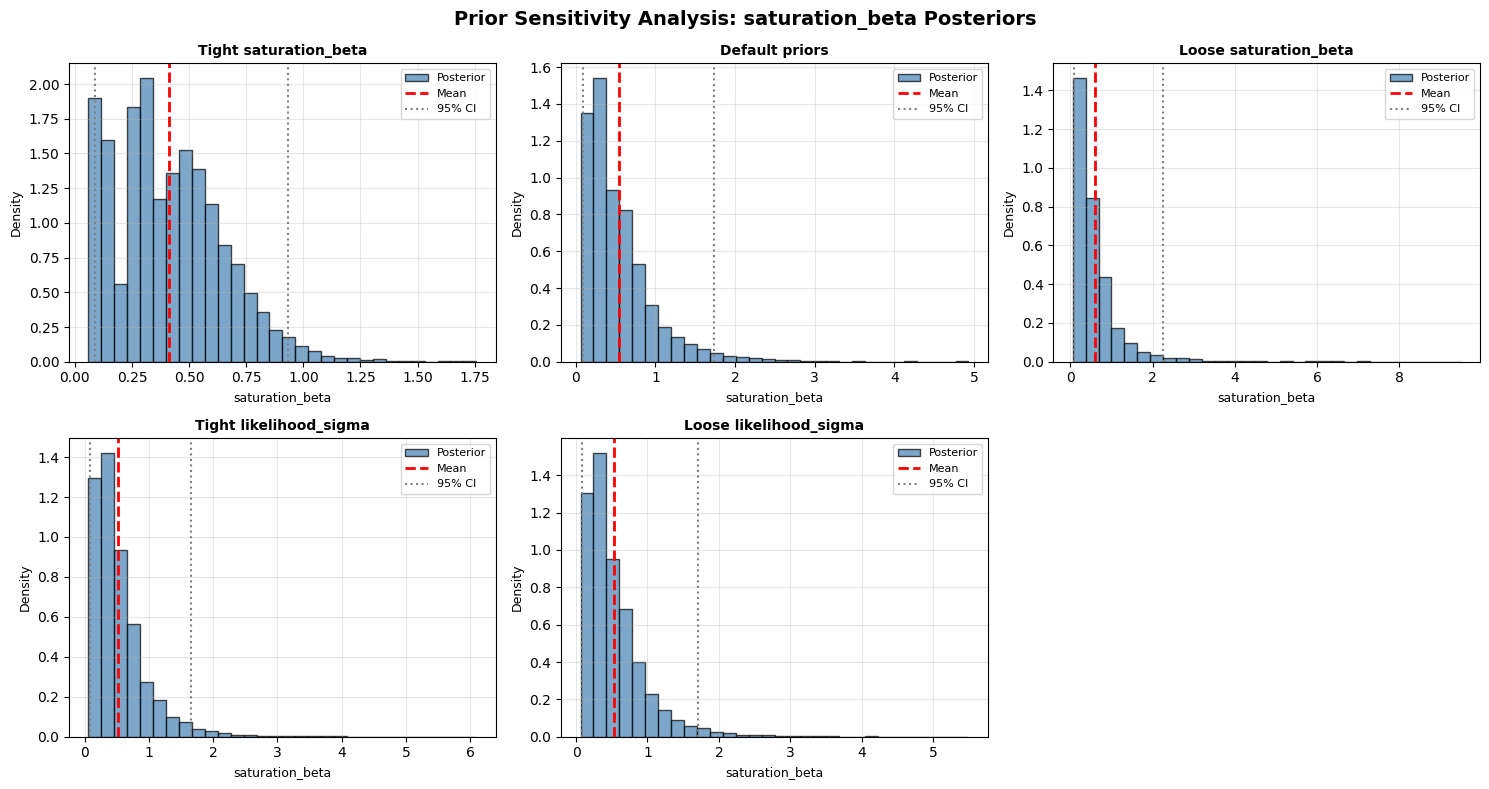

In [10]:
def plot_prior_posterior_comparison(
    results: dict[str, dict],
    parameter: str = "saturation_beta"
) -> None:
    """Plot prior and posterior distributions for a parameter.
    
    Args:
        results: Dictionary with results for each prior specification
        parameter: Parameter name to plot
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, (spec_id, result) in enumerate(results.items()):
        if idx >= len(axes):
            break
        
        ax = axes[idx]
        mmm = result["mmm"]
        
        # Extract posterior samples for the parameter
        if parameter in mmm.idata.posterior:
            posterior_samples = mmm.idata.posterior[parameter].values.flatten()
            
            # Plot posterior
            ax.hist(posterior_samples, bins=30, alpha=0.7, density=True, 
                   color='steelblue', edgecolor='black', label='Posterior')
            
            # Add vertical lines for mean and credible interval
            mean_val = np.mean(posterior_samples)
            ci_lower = np.percentile(posterior_samples, 2.5)
            ci_upper = np.percentile(posterior_samples, 97.5)
            
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label='Mean')
            ax.axvline(ci_lower, color='gray', linestyle=':', linewidth=1.5)
            ax.axvline(ci_upper, color='gray', linestyle=':', linewidth=1.5, label='95% CI')
            
            ax.set_title(result["name"], fontsize=10, fontweight='bold')
            ax.set_xlabel(parameter, fontsize=9)
            ax.set_ylabel('Density', fontsize=9)
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f"{parameter}\nnot available", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(result["name"], fontsize=10, fontweight='bold')
    
    # Hide unused subplots
    for idx in range(len(results), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Prior Sensitivity Analysis: {parameter} Posteriors', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Plot saturation_beta posteriors
rprint("\n[bold blue]Visualizing saturation_beta posteriors...[/bold blue]")
plot_prior_posterior_comparison(results, parameter="saturation_beta")

## Which Prior Specification is Best?

Evaluate based on:
1. **Causal accuracy**: ROAS error vs ground truth
2. **Convergence**: Clean MCMC diagnostics
3. **Interpretability**: Reasonable posterior distributions

In [11]:
# Create summary table
console = Console()
table = Table(
    title="Prior Specification Comparison: Overall Performance",
    show_header=True,
    header_style="bold green"
)

table.add_column("Prior Spec", style="cyan")
table.add_column("ROAS MAPE %", justify="right")
table.add_column("Divergences %", justify="right")
table.add_column("Max R-hat", justify="right")
table.add_column("Recommendation")

# Find best specification
best_spec_id = min(results.keys(), key=lambda k: results[k]["roas_error"])

for spec_id, result in results.items():
    is_best = (spec_id == best_spec_id)
    conv = result["convergence"]
    
    # Recommendation
    if is_best and conv["divergence_rate"] < 0.01:
        recommendation = "[bold green]✓ Best[/bold green]"
    elif conv["divergence_rate"] > 0.05 or conv["max_rhat"] > 1.05:
        recommendation = "[red]⚠ Poor convergence[/red]"
    else:
        recommendation = "[yellow]Acceptable[/yellow]"
    
    table.add_row(
        result["name"],
        f"{result['roas_error']:.1f}%",
        f"{conv['divergence_rate']*100:.1f}%",
        f"{conv['max_rhat']:.3f}",
        recommendation
    )

console.print("\n")
console.print(table)

# Print recommendation
best_result = results[best_spec_id]
rprint(f"\n[bold magenta]Recommendation:[/bold magenta]")
rprint(f"The [green]{best_result['name']}[/green] specification yields:")
rprint(f"  - Lowest ROAS error: [yellow]{best_result['roas_error']:.1f}%[/yellow]")
rprint(f"  - Convergence: [green]{best_result['convergence']['divergence_rate']*100:.1f}% divergences[/green]")
rprint(f"\n[bold blue]Key Insight:[/bold blue]")
rprint("Prior choice affects causal estimates. Use domain knowledge, not CV, to select priors.")

                 Prior Specification Comparison: Overall Performance                 
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Prior Spec             ┃ ROAS MAPE % ┃ Divergences % ┃ Max R-hat ┃ Recommendation ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ Tight saturation_beta  │       20.8% │          0.0% │     1.005 │ Acceptable     │
│ Default priors         │       21.0% │          0.0% │     1.007 │ Acceptable     │
│ Loose saturation_beta  │       21.0% │          0.0% │     1.008 │ Acceptable     │
│ Tight likelihood_sigma │       20.7% │          0.0% │     1.009 │ ✓ Best         │
│ Loose likelihood_sigma │       20.8% │          0.0% │     1.007 │ Acceptable     │
└────────────────────────┴─────────────┴───────────────┴───────────┴────────────────┘

Recommendation:

The Tight likelihood_sigma specification yields:

- Lowest ROAS error: 20.7%

- Convergence: 0.0% divergences

Key Insight:

Prior choice affects causal estimates. Use domain knowledge, not CV, to select priors.

## Visualize ROAS Estimates Across All Specifications

Visualizing ROAS estimates...

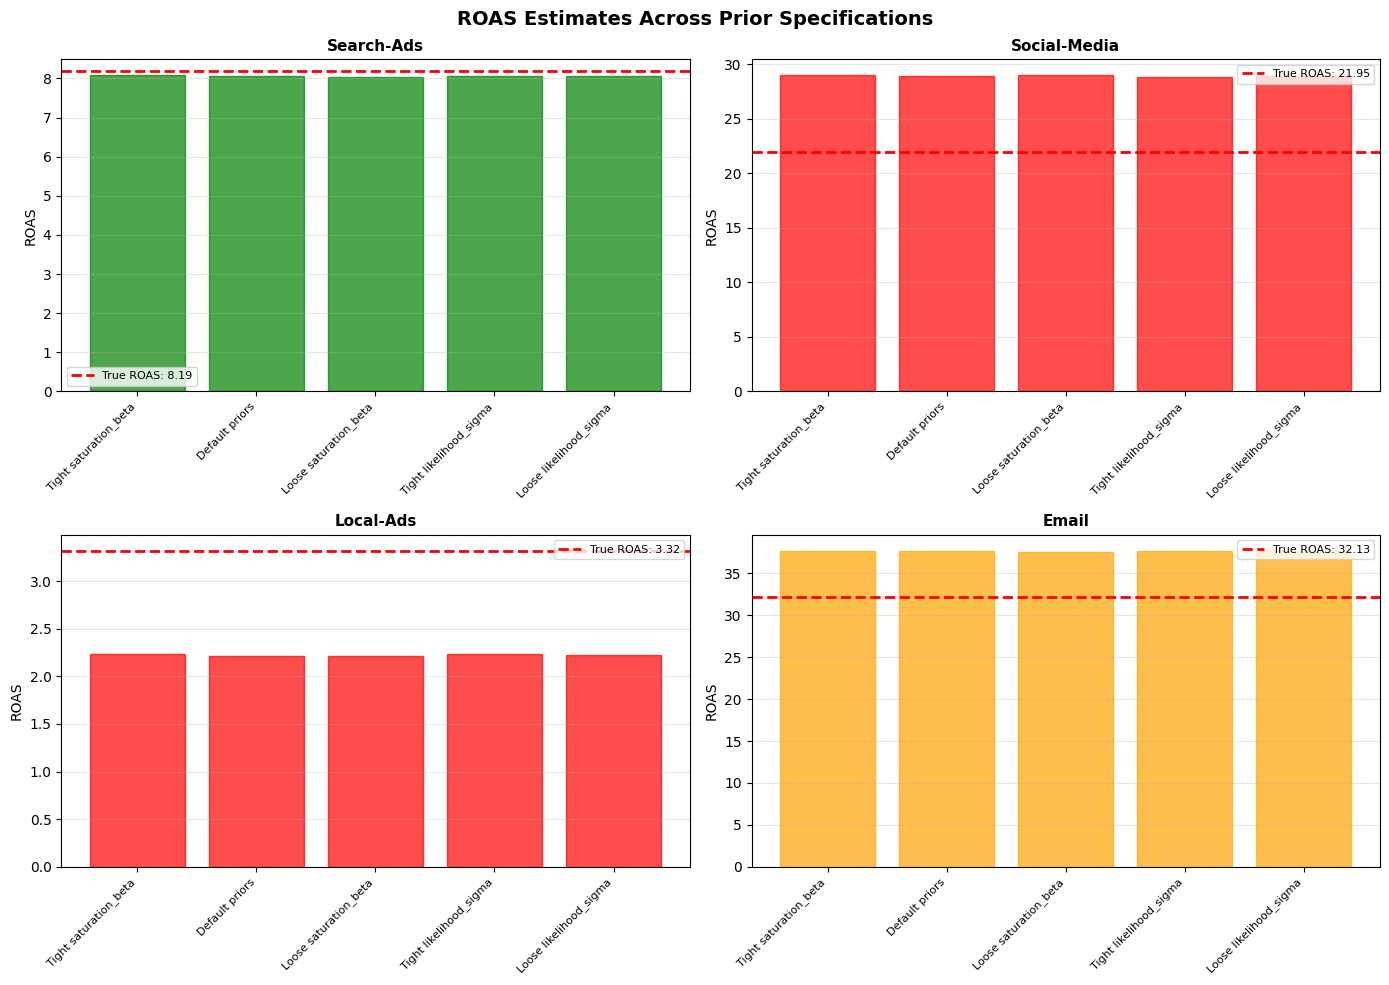

In [12]:
def plot_roas_comparison(
    results: dict[str, dict],
    true_roas: dict[str, float],
    channel_columns: list[str]
) -> None:
    """Plot ROAS estimates across prior specifications.
    
    Args:
        results: Dictionary with results for each prior specification
        true_roas: Ground truth ROAS values
        channel_columns: List of channel column names
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, channel in enumerate(channel_columns):
        ax = axes[idx]
        channel_name = channel.split('_', 1)[1] if '_' in channel else channel
        
        # Extract ROAS estimates
        spec_names = [result["name"] for result in results.values()]
        roas_values = [result["roas"][channel] for result in results.values()]
        
        # Plot
        x_pos = np.arange(len(spec_names))
        bars = ax.bar(x_pos, roas_values, alpha=0.7, color='steelblue', edgecolor='black')
        
        # Add ground truth line
        true_val = true_roas.get(channel_name, 0.0)
        ax.axhline(true_val, color='red', linestyle='--', linewidth=2, label=f'True ROAS: {true_val:.2f}')
        
        # Color bars based on error
        for bar, roas_val in zip(bars, roas_values):
            error_pct = abs((roas_val - true_val) / true_val * 100) if true_val != 0 else 0
            if error_pct < 10:
                bar.set_color('green')
            elif error_pct < 25:
                bar.set_color('orange')
            else:
                bar.set_color('red')
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels(spec_names, rotation=45, ha='right', fontsize=8)
        ax.set_ylabel('ROAS', fontsize=10)
        ax.set_title(f'{channel_name}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('ROAS Estimates Across Prior Specifications', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Plot comparison
rprint("\n[bold blue]Visualizing ROAS estimates...[/bold blue]")
plot_roas_comparison(results, true_roas, channel_columns)

## Save Results

In [13]:
def save_sensitivity_results(
    results: dict[str, dict],
    sensitivity_df: pd.DataFrame,
    output_dir: str | Path
) -> None:
    """Save prior sensitivity analysis results.
    
    Args:
        results: Dictionary with results for each prior specification
        sensitivity_df: DataFrame with sensitivity metrics
        output_dir: Directory to save results
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save sensitivity metrics
    sensitivity_path = output_dir / "prior_sensitivity_metrics.csv"
    sensitivity_df.to_csv(sensitivity_path, index=False)
    
    # Save ROAS comparison
    roas_data = []
    for spec_id, result in results.items():
        for channel, roas in result["roas"].items():
            roas_data.append({
                "spec_id": spec_id,
                "spec_name": result["name"],
                "channel": channel,
                "roas": roas
            })
    
    roas_df = pd.DataFrame(roas_data)
    roas_path = output_dir / "prior_sensitivity_roas.csv"
    roas_df.to_csv(roas_path, index=False)
    
    # Save summary
    summary = {
        spec_id: {
            "name": result["name"],
            "description": result["description"],
            "roas_error_pct": float(result["roas_error"]),
            "divergence_rate": float(result["convergence"]["divergence_rate"]),
            "max_rhat": float(result["convergence"]["max_rhat"])
        }
        for spec_id, result in results.items()
    }
    
    summary_path = output_dir / "prior_sensitivity_summary.json"
    with open(summary_path, "w") as f:
        json.dump(summary, f, indent=2)
    
    rprint(f"\n[bold green]Results saved to {output_dir}[/bold green]")
    rprint(f"  - Sensitivity metrics: {sensitivity_path}")
    rprint(f"  - ROAS comparison: {roas_path}")
    rprint(f"  - Summary: {summary_path}")


# Save results
output_dir = Path("../models/prior_sensitivity_analysis")
save_sensitivity_results(results, sensitivity_df, output_dir)

Results saved to ../models/prior_sensitivity_analysis

- Sensitivity metrics: ../models/prior_sensitivity_analysis/prior_sensitivity_metrics.csv

- ROAS comparison: ../models/prior_sensitivity_analysis/prior_sensitivity_roas.csv

- Summary: ../models/prior_sensitivity_analysis/prior_sensitivity_summary.json

## Summary and Key Takeaways

### What We Did

1. **Defined multiple prior specifications** for key MMM parameters
2. **Fitted separate models** with each specification (fixed model structure)
3. **Compared ROAS estimates** to ground truth
4. **Quantified sensitivity** using coefficient of variation
5. **Visualized prior influence** on posteriors

### Key Insights

**For novice practitioners:**

1. **Priors matter**: Different prior specifications can yield different causal estimates
2. **Not all priors are equal**: Some parameters are more sensitive than others
3. **Data updates beliefs**: Strong data will overwhelm weak priors (large posterior shift)
4. **Domain knowledge crucial**: Use expert knowledge, not CV, to select priors
5. **Report sensitivity**: Always show how results depend on prior choice

### Methodological Distinction

| Parameter Type | Optimization Method | Rationale |
|---------------|---------------------|------------|
| **Model structure** (seasonality, lag) | ✅ Cross-validation | Structural assumptions about data patterns |
| **Priors** (effect sizes, saturation) | ❌ Domain knowledge | Causal assumptions—CV would conflate correlation with causation |

### Best Practices

1. **Always perform prior sensitivity analysis** before making business decisions
2. **Document prior choices** and their justification
3. **Use informative priors** when you have domain knowledge (e.g., previous studies)
4. **Check posterior robustness**: If ROAS varies ±50% across reasonable priors, be cautious
5. **Combine with experiments**: Use RCT data to calibrate priors when possible

### Next Steps

- Incorporate expert elicitation for prior specification
- Use historical campaign data to inform priors
- Implement prior predictive checks (do priors generate realistic data?)
- Consider hierarchical priors for multi-geo models